In [1]:
import bempp.api
from bempp.api.assembly.blocked_operator import BlockedOperator
import math
import numpy as np
import scipy 
import cmath
from numba import objmode
from numpy.linalg import slogdet
from bempp.api.operators.far_field import helmholtz as helmholtz_farfield
import matplotlib.pyplot as plt

In [2]:
h = 0.2

dist = 0.5
sphere1 = bempp.api.shapes.sphere(h=h, origin=((dist/2) + 1, 0, 0))
sphere2 = bempp.api.shapes.sphere(h=h, origin=(-((dist/2) + 1), 0, 0))

space_sphere1 = bempp.api.function_space(sphere1, "P", 1)
space_sphere2 = bempp.api.function_space(sphere2, "P", 1)

wavenumber = 0.8j

slp11 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere1, space_sphere1, wavenumber)
slp12 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere1, space_sphere1, wavenumber)
slp21 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere2 , space_sphere2 , wavenumber)
slp22 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere2 , space_sphere2 , wavenumber)

mat11 = slp11.weak_form().A
mat12 = slp12.weak_form().A
mat21 = slp21.weak_form().A
mat22 = slp22.weak_form().A
mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

mat = np.block([[mat11,mat12],[mat21,mat22]])  
mat2 = np.block([[mat11,mat12_zero],[mat21_zero,mat22]])

combined = np.linalg.inv(mat2).dot(mat)
sign, logdet = slogdet(combined)
print(logdet)

-0.11725914620404754


In [3]:
evals, evects = np.linalg.eig(combined)

In [4]:
import krypy

In [ ]:
x = np.ones(combined.shape[0]) / (np.ones(combined.shape[0]).T @ mat2 @ np.ones(combined.shape[0]))

rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

index_ = 150

for k in range(150, 200):
    V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), ip_B = mat2, maxiter = k, ortho ='dmgs')
    A_m = V_m.T @ (mat - rho_*mat2) @ V_m
    evalue, evect = np.linalg.eig(A_m)
    mu_ = sorted(evalue)[index_]
    v_index = list(evalue).index(sorted(evalue)[index_])
    v_ = evect[:,v_index]
    rho_ += mu_
    x = V_m @ v_
print(rho_, sorted(evals)[index_])

In [74]:
x = np.ones(combined.shape[0]) / (np.ones(combined.shape[0]).T @ mat2 @ np.ones(combined.shape[0]))

rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

index_ = 0

for k in range(index_, index_ + 100):
    V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = k, ortho ='dmgs')
    A_m = V_m.T @ (mat - rho_*mat2) @ V_m
    B_m = V_m.T @ mat2 @ V_m
    evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
    mu_ = sorted(evalue)[index_]
    v_index = list(evalue).index(sorted(evalue)[index_])
    v_ = evect[:,v_index]
    rho_ += mu_
    x = V_m @ v_
print(rho_, sorted(evals)[index_])

0.7021660931758322 (0.7021660931758336+0j)


In [6]:
for num_ in range(1, 100):
    result_1 = []
    for index_ in range(num_+1):
        x = np.ones(combined.shape[0]) / (np.ones(combined.shape[0]).T @ mat2 @ np.ones(combined.shape[0]))

        rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

        for k in range(index_, index_ + 50):
            V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = k, ortho ='dmgs')
            A_m = V_m.T @ (mat - rho_*mat2) @ V_m
            B_m = V_m.T @ mat2 @ V_m
            evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
            mu_ = evalue[index_]
            v_index = list(evalue).index(evalue[index_])
            v_ = evect[:,v_index]
            rho_ += mu_
            x = V_m @ v_
        result_1.append(rho_)
        
    result_2 = []
    for index_ in range(1, num_ + 1):
        x = np.ones(combined.shape[0]) / (np.ones(combined.shape[0]).T @ mat2 @ np.ones(combined.shape[0]))

        rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

        for k in range(index_, index_ + 50):
            V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = k, ortho ='dmgs')
            A_m = V_m.T @ (mat - rho_*mat2) @ V_m
            B_m = V_m.T @ mat2 @ V_m
            evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
            mu_ = evalue[-index_]
            v_index = list(evalue).index(evalue[-index_])
            v_ = evect[:,v_index]
            rho_ += mu_
            x = V_m @ v_
        result_2.append(rho_)
        
    result_ = result_1 + result_2 
    
    logdet_approx = 0
    for i in range(len(result_)):
        logdet_approx += np.log(result_[i])
    err = (logdet_approx - logdet)/logdet
    print(abs(err))

0.649926784474094
0.7276763559884868
0.4567362418465344
0.20430926929211768
0.20986368628837684
0.16940238106242417
0.17303651355341704
0.10333976383228939
0.05594113822358853
0.05626925660730026
0.050755942770706435
0.050941246269140275
0.03948658694666768
0.039632040711542076
0.023637959815070657
0.014403296535112152
0.013650952049914138
0.012858795735708826
0.01271683054519026
0.011354330382346763
0.011214002925817696
0.008350540049858546
0.008240039444619006
0.005685714808982978
0.0038393005084773673
0.003703165541528184
0.003459049621051068
0.0030419000895551707
0.0029785158052707747
0.001738077372226863
0.001139583522215744
0.0019040506677744707
0.0010342538009773339
0.00032701933382492767
0.00032720846025723125
7.725238463035056e-05
0.0002136353578839144
0.00035833494416075053
0.0003872075407575833
0.00022123091729802716
0.00031196149921175486
0.0003749238965290773
0.00046947918045714475
0.000580374338055121
0.0007325799385270556
0.0008189893557248217
0.0009119591008232887
0.000

In [ ]:
num_1 = 50
result_1 = []
for index_ in range(num_1+1):
    x = np.ones(combined.shape[0]) / (np.ones(combined.shape[0]).T @ mat2 @ np.ones(combined.shape[0]))

    rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

    for k in range(index_, index_ + 100):
        V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = k, ortho ='dmgs')
        A_m = V_m.T @ (mat - rho_*mat2) @ V_m
        B_m = V_m.T @ mat2 @ V_m
        evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
        mu_ = evalue[index_]
        v_index = list(evalue).index(evalue[index_])
        v_ = evect[:,v_index]
        rho_ += mu_
        x = V_m @ v_
    result_1.append(rho_)
    
   

In [125]:
num_2 = 50
result_2 = []
for index_ in range(1, num_2 + 1):
    x = np.ones(combined.shape[0]) / (np.ones(combined.shape[0]).T @ mat2 @ np.ones(combined.shape[0]))

    rho_ = (x.T @ mat @ x)/(x.T @ mat2 @ x)

    for k in range(index_, index_ + 50):
        V_m, H_m = krypy.utils.arnoldi((mat - rho_*mat2), x.reshape(combined.shape[0],1), maxiter = k, ortho ='dmgs')
        A_m = V_m.T @ (mat - rho_*mat2) @ V_m
        B_m = V_m.T @ mat2 @ V_m
        evalue, evect = scipy.linalg.eigh(A_m, B_m, eigvals_only=False)
        mu_ = evalue[-index_]
        v_index = list(evalue).index(evalue[-index_])
        v_ = evect[:,v_index]
        rho_ += mu_
        x = V_m @ v_
    result_2.append(rho_)

In [126]:
result_ = result_1 + result_2 

In [127]:
logdet_approx = 0
for i in range(len(result_)):
    logdet_approx += np.log(result_[i])
print(logdet_approx)

-0.11728405687100812


In [128]:
(logdet_approx - logdet)/logdet

0.00021244114226483347

In [106]:
for i in range(len(result_)):
    print(sorted(result_)[i+1], sorted(evals[0:len(result_)])[i])

0.7021660931758322 (0.7021660931758336+0j)
0.9043124458898857 (0.9043124458898861+0j)
0.9043860910573961 (0.9043860910573976+0j)
0.9421934664049058 (0.942193466404906+0j)
0.9737525286945633 (0.9737525286945633+0j)
0.9737893966140317 (0.9737893966140311+0j)
0.97909310969107 (0.9790931096910711+0j)
0.979103936899847 (0.9791039368998471+0j)
0.9875697482945321 (0.9875697482945306+0j)
0.9932273305554089 (0.9932273305554075+0j)
0.99323467571907 (0.9932346757190679+0j)
0.9939224875522542 (0.9939224875522522+0j)
0.9939376035481411 (0.9939376035481406+0j)
0.9953101015920114 (0.9953101015920109+0j)
0.9953150180428074 (0.9953150180428059+0j)
0.9972053230845198 (0.9972053230845186+0j)
0.9982935273482993 (0.998293527348301+0j)
0.9982974316592778 (0.9982974316592799+0j)
0.9983927751699329 (0.9983927751699344+0j)
0.9983944529521848 (0.9983944529521863+0j)
0.9985888466845899 (0.9985888466845909+0j)
0.998590873616076 (0.9985908736160748+0j)
0.998939138105022 (0.998939138105021+0j)
0.9989452777604302 (0

IndexError: list index out of range

In [59]:
print(sorted(evals)[100], np.log(sorted(evals)[100]), np.log(1.0000000212553286))

(0.9999998066208537+0j) (-1.9337916494936497e-07+0j) 2.125532838241054e-08


In [19]:
mat_A = mat + 2*mat2
mat_B = 5*mat + 4*mat2

In [5]:
b = np.ones(combined.shape[0]) / np.linalg.norm(np.ones(combined.shape[0]))

In [ ]:
err_list= []
for i in range(1, combined.shape[0] +1):
    num_iteration = i
    Q_k, H_Q= krypy.utils.arnoldi((np.linalg.inv(mat_B) @ mat_A), (np.linalg.inv(mat_B) @ b).reshape(combined.shape[0],1), maxiter = num_iteration, ortho ='dmgs')
    Z_k, R_k = np.linalg.qr(mat_B @ Q_k)
    H_k = Z_k.T @ mat_A @ Q_k
    
    evals_new, evecs = np.linalg.eig(np.linalg.inv(R_k) @ H_k)
    evals_test = []
    for j in range(len(evals_new)):
        evals_test.append((evals_new[j]*4 - 2)/(1 - evals_new[j]*5))
        
    sum_test = 0
    for k in range(len(evals_new)):
        sum_test += np.log(evals_test[k])
    err_list.append(abs(sum_test - logdet)/logdet)
    print(abs((sum_test - logdet)/logdet))

3.2501836840920992
1.6835028967742405
0.6456698591396417
0.12744953515673882
0.04130056601071034
0.4260598492941377
0.24184113372773217
0.09793836465493974
0.16934999512666052
0.016421562515893565
0.49861571586468406
0.03787523505244745
0.043982079608010226
0.042392842091708405
0.008504125917219696
0.0006572716468086899
0.029131944355950613
0.04087321261444335
0.12136275807630625
0.014450929838136414
0.0010000597254849718
0.03852831913507381
0.14746411713116447
0.15453015028172806
0.028127894765129103
0.007026087612343839
0.009825348520322581
0.0037561147266790803
0.0038792440381949637
0.0029007781083869645
0.0039704579212808955
0.006102183754914692
0.011297668969213937
0.02542669560176787
0.0025221744785736333
0.001339030690666251
0.02431523660104514
0.0315273890431404
0.00478300563061308
0.0013531280242470684
0.0017642342728415585
0.0006827151106165959
0.003044394952749172
0.0010056295268958812
0.0012770012621682425
0.0022052378144021344
0.0002797457082569678
0.00034300147190953055
0

In [49]:
num_iteration = 200

In [50]:
Q_k, H_Q= krypy.utils.arnoldi((np.linalg.inv(mat_B) @ mat_A), (np.linalg.inv(mat_B) @ b).reshape(combined.shape[0],1), maxiter = num_iteration, ortho ='dmgs')
Z_k, R_k = np.linalg.qr(mat_B @ Q_k)
H_k = Z_k.T @ mat_A @ Q_k

In [51]:
evals_new, evecs = np.linalg.eig(np.linalg.inv(R_k) @ H_k)

In [52]:
evals_test = []
for i in range(len(evals_new)):
    evals_test.append((evals_new[i]*4 - 2)/(1 - evals_new[i]*5))

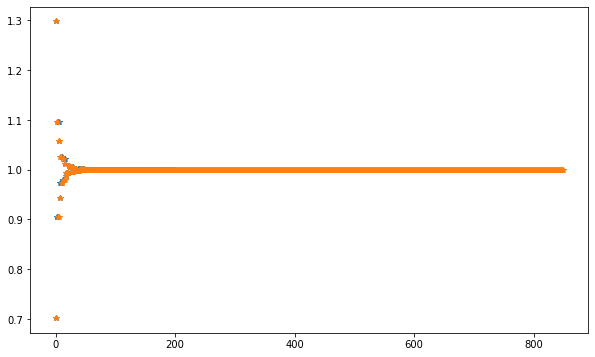

In [53]:
plt.figure(figsize = [10,6])

plt.plot(range(len(evals_new)), evals_test, '*')
plt.plot(range(len(evals)), evals, '*')

In [54]:
sum_test = 0
for i in range(len(evals_new)):
    sum_test += np.log(evals_test[i])
print((sum_test - logdet)/logdet)

3.1325073227374573e-07


In [ ]:
[3.2501836840920992, 1.6835028967742405, 0.6456698591396417 0.12744953515673882, 0.04130056601071034, 0.4260598492941377,
 0.24184113372773217, 0.09793836465493974, 0.16934999512666052, 0.016421562515893565, 0.49861571586468406, 0.03787523505244745,
 0.043982079608010226, 0.042392842091708405, 0.008504125917219696, 0.0006572716468086899, 0.029131944355950613, 0.04087321261444335,
 0.12136275807630625, 0.014450929838136414, 0.0010000597254849718, 0.03852831913507381
0.14746411713116447
0.15453015028172806
0.028127894765129103
0.007026087612343839
0.009825348520322581
0.0037561147266790803
0.0038792440381949637
0.0029007781083869645
0.0039704579212808955
0.006102183754914692
0.011297668969213937
0.02542669560176787
0.0025221744785736333
0.001339030690666251
0.02431523660104514
0.0315273890431404
0.00478300563061308
0.0013531280242470684
0.0017642342728415585
0.0006827151106165959
0.003044394952749172
0.0010056295268958812
0.0012770012621682425
0.0022052378144021344
0.0002797457082569678
0.00034300147190953055
0.0010513720384100096
0.000967788586924751
0.00045515633143285216
0.0008888079989380252
0.00027981361618287985
0.0003948916456558122
0.0019881234943894205
0.0013970460279282037
0.0002430929905111448
0.0007675195907021492
0.00017236666970743138
0.0006722720719795704
0.0006655370274574093
0.0002125468664541404
0.0006034928842136091
0.00040788288820752254
0.00013509960422829735
0.0006639216089202786
0.0012463166233551443
0.0002706032772505443
0.0003520849629856148
0.0012664527296298888
0.0003322764231728841
0.0007459835583145786
0.001283639097203586
8.186036442445926e-05
0.0010313875452439543
0.0007318923881677703
0.00025282940894522386
0.0008787213896472372
0.0017476794284380884
9.220497056908319e-05
0.00019256107408832296
0.00010745834694302178
0.0001952715332029433
0.00031087396825521193
6.353056881054651e-05
0.0001881313546824079
2.206239849860896e-05
9.073993104801379e-05
0.00014659134999214018
3.817173518612052e-05
0.00047997153173974234
0.0002700752604613199
0.00023221611172065284
0.00045667045936128507
0.0003379852450967401
0.0002593514463028969
0.00043853849812614573
0.0003868217496455402
0.00034378129780327985
0.0003683769845655579
0.0007890451082125334
0.0006734492580341353
0.00025083726126100264
0.0002356747831294677
0.0006794514170559308
0.0002790579723297391
1.6748790608583907e-05
4.6255610274302025e-06
6.661101792492894e-06
3.8133343478537735e-05
4.251429485121884e-05
1.9217204932864296e-06
5.233656137921432e-06
1.8376107891395662e-05
9.484804075769632e-06
2.6811944776569385e-05
7.323934902030182e-05
1.055815579952735e-05
2.7815033194998446e-06
9.63203226782759e-06
6.414890622387101e-06
1.4796905284256528e-05
1.6971396003391216e-05
1.2436030933042104e-05
4.459794707293599e-06
4.3855711809364746e-05
5.291611985528636e-05
2.767036806308205e-05
8.871953191134967e-05
9.701379762098421e-05
4.687241211543878e-06
1.4322882178907547e-05
1.257152346733653e-05
2.4011288714739868e-05
1.4699510620883422e-05
1.0592644260922355e-05
2.641138101861042e-05
3.510934614785032e-05
2.286118659539256e-05
1.9799957596312407e-05
1.895362247434316e-05
4.818588798806607e-06
3.877682821337367e-06
4.283987673382142e-07
7.646877100993194e-06
2.6970713628323688e-06
5.8238668485496366e-06
1.0963931750149859e-05
1.1076617238694845e-05
1.0440036288916952e-05
3.196907298018139e-06
6.1400225513861215e-06
1.62952523736536e-05
2.691167471500145e-06
5.857186375579352e-06
4.462651268451966e-06
8.259537921288628e-06
2.5516752217719856e-05
7.191875982365573e-07
8.980381744843055e-07
9.198206028228885e-06
1.5093342642917223e-05
2.1408190826426752e-05
2.4273348565052353e-05
6.4895322082635215e-06
6.746401525644646e-06
5.288131436969908e-06
5.245010163209544e-06
3.8907565453546225e-06
1.692407211550911e-06
1.6470084748021359e-06
1.0395408576830622e-06
6.563783815876629e-07
1.7114138581514795e-06
8.672459633335223e-08
2.607851152352874e-06
2.4302747272600338e-06
1.1808426367231436e-06
2.0682638844338374e-07
1.0614026118497167e-06
1.3791495003299535e-06
2.969501820409936e-07
5.777620409968042e-07
1.749146335952349e-06
1.907026596756119e-06
7.638245633928556e-07
1.3352123574845932e-06
3.4786696399239274e-06
1.6094724457019518e-06
7.79015587773325e-07
3.845786753131166e-06
2.551160712404534e-06
9.59724485414885e-08
1.2948716327289151e-06
3.370319836654756e-06
5.451468692206996e-06
4.466762760019363e-06
9.110057956147765e-07
1.1415154157528426e-08
3.1325073227374573e-07
1.9000515167957588e-09
1.307377604454546e-07
2.0684012916293044e-08
2.668109524266501e-07
3.446098326975159e-07
4.535144795493294e-07
3.439543150082509e-07
1.0507123688496808e-07
2.283950583086261e-07
6.922600225392478e-08
4.887646693385387e-07
7.19971720851924e-07
1.4516029478957124e-06
1.5428604337611025e-06
7.97374679723993e-07
5.906319652692625e-07
1.9914406103997705e-08
2.171485434608732e-07
1.5904475592521688e-07
1.628152381992395e-08
1.6368553047989532e-07
1.3321496905037854e-07
1.9263297644653184e-07
2.802934445355365e-07
6.117831131792448e-08
2.472108745876644e-07
3.5620098466507237e-07
4.0468354264787023e-07
2.8163014347517236e-07
2.686459073422897e-07
9.080219619307228e-08
5.873729150361107e-08
4.8935939711688775e-08
1.0880304877556483e-07
1.0955328335214918e-07
1.7915734777386003e-07
8.542764678714309e-09
6.76491503887422e-09
8.03749348078507e-08
1.559520932475052e-07
2.577152676127583e-07
1.3500254208877505e-07
1.8528463145695796e-08
5.48738895087562e-08
5.887223166348877e-08
1.4794169354569972e-07
1.2895039535052323e-07
1.5793796268913562e-08
2.7671461311351853e-08
2.406541639788136e-08
1.3058080561745518e-08
6.880790783279076e-08
8.154075724060167e-08
3.6550356719083255e-08
6.194315921915987e-09
2.2242878204324448e-08
6.203974463887946e-08
4.425323442834994e-08
2.140110222767891e-08
6.605160122522173e-08
1.3869566193763397e-07
1.3025143713417877e-07
1.1781101707095812e-07
5.991488670830604e-08
4.393492789832003e-08
2.1670530563317473e-08
1.7267487345546172e-08
2.810833621103945e-08
7.077510165523587e-09
1.4269809621146151e-08
2.0167467383473515e-08
1.1688915220722179e-08
4.27110042624736e-09
8.714181933289624e-09
5.886588707994979e-09
1.0017004787637573e-09
1.2592319746527107e-08
7.055153698467733e-09
1.1741566813803525e-08
2.6304874137911958e-08
3.357839628733893e-08
4.423291751151285e-08
4.4159776090153007e-08
1.9373126187160947e-08
8.343401929082751e-10
2.102533536755504e-09
9.298820843861914e-09
1.4410791976655392e-08
9.442177920843878e-09
1.0754150642711269e-08
9.288338102521101e-09
7.3907912570698336e-09
2.803950633232857e-09
2.7872437901103125e-09
6.9807521894168885e-09
1.6525174858731051e-09
1.7643127214584063e-09
1.6188190460838665e-09
1.1753891340121087e-09
2.095241076601768e-09
1.928340112651874e-09
3.3926775206000286e-10
1.8325609028835465e-09
9.022432615592084e-10
4.223261949181597e-10
5.560418908857286e-10
1.0942125972659754e-09
7.520513894090572e-10
6.542064737556117e-10
3.5919004971910044e-09
7.465597528016354e-09
5.0462981601659935e-09
2.978990151720164e-09
4.093404983286126e-09
5.192559107870843e-09
2.788465413586088e-09
1.097418264139145e-09
6.084638821899951e-10
9.149164511939227e-10
2.915873925067023e-10
8.828030921265463e-10
5.84412504283862e-10
6.155390491155267e-10
5.137546877137123e-10
9.417637633174285e-11
7.708882032440151e-10
5.315909585469062e-10
3.819271704840356e-10
1.1178741255568008e-09
1.099938084466866e-09
3.3919307230673657e-10
4.6201037670612185e-10
3.6460466321491266e-10
1.968871927392123e-10
4.699732977192132e-10
8.233886615473553e-11
6.243819130217001e-10
4.0091133185119076e-10
1.174531441188146e-10
1.010208763173126e-10
8.806530016707804e-12
4.198080315104794e-10
5.092521258543435e-10
1.0121710299071272e-10
5.333419679757087e-10
2.451665288872522e-10
1.0976266810099878e-10
9.808232862500193e-11
3.6439234074683077e-10
3.4070998260406416e-10
8.975772563729605e-13
8.290908335162437e-11
3.6913338074063936e-11
3.147437968879551e-11
1.6161953131993028e-11
6.866039946099807e-12
1.910860789736035e-10
1.3480819803159556e-10
1.6797003243048675e-10
1.46283671179694e-10
1.6551163649570573e-10
6.386255078007725e-11
6.471692976395863e-11
6.289834166777893e-11
1.2318703427134057e-10
6.598707732664252e-11
2.3777394342248107e-11
2.1549783698860465e-11
7.721602444296027e-11
1.0894367619513105e-11
2.9693308996396155e-11
3.361784246439818e-11
9.22954170311712e-11
9.482908447637588e-12
4.576993074628938e-11
9.98566532858067e-12
1.3225299062586083e-11
2.135651581124746e-11
4.3439946114668276e-11
3.062520816789941e-11
1.3925466131244104e-11
2.919019706115862e-11
4.479743703378719e-11
5.48528113555118e-11
6.580138393064448e-11
4.547937798199671e-11
3.720045864684358e-11
3.1797715799609185e-11
2.1784474587492796e-11
6.60164284816505e-12
1.171371457967529e-11
4.785185077752049e-12
9.435212820749626e-12
8.633263521015556e-12
9.176733294389058e-12
1.815830507826137e-11
3.353570657094844e-11
3.611233558578174e-11
8.110978653877651e-12
3.6393065181261255e-13
9.712746927579081e-12
6.4197366979744855e-12
1.0424985842248447e-11
1.7310080368817142e-12
8.839431714660295e-12
9.900689000775318e-12
9.502318082400926e-12
6.6909981789353015e-12
2.306515542757874e-11
1.5728550189899437e-11
6.0109508536295215e-12
5.596602492004821e-12
1.2208778617571927e-11
3.830325728540941e-12
2.3772068527831335e-12
1.9601364082343056e-12
1.0275744687147406e-11
1.2708340009864947e-11
1.2425243385755754e-11
1.3566151185259358e-11
1.394759784893157e-11
1.1150006711518062e-11
1.7211020220665223e-11
9.344200569938602e-12
1.4366798619247106e-11
1.7488909381789127e-11
1.307321747312943e-11
1.44894107022643e-11
1.6882950052592193e-11
9.9088552495477e-12
1.3522716209904812e-11
5.181307318928249e-12
1.1078995852627797e-11
1.2680645774897744e-11
1.1328717373058565e-11
6.886869798040951e-12
1.0894485970944588e-11
1.3017592300332055e-11
1.691230120760017e-11
1.2215879703460953e-11
1.5203779942700373e-11
1.4738422114106166e-11
1.2732365350456154e-11
1.5088387297003693e-11
1.411305315014589e-11
1.4261584196658028e-11
9.886486828997266e-12
1.3778592004772737e-11
1.5449477514460692e-11
1.360852099773055e-11
1.6163491700602315e-11
1.9298976174902007e-11
1.9426795720904485e-11
1.2726684481744931e-11
1.6212015787510663e-11
1.8477380537541628e-11
1.3689591728296938e-11
1.3298203544380089e-11
1.603945940040732e-11
1.9961152434053734e-11
1.672861978593735e-11
1.5496581384191237e-11
2.0421539502525624e-11
1.669453457367002e-11
2.3217000314172423e-11
1.489784149231481e-11
1.7334697466565767e-11
2.3846866632529082e-11
2.0696469877862438e-11
1.7508792422278404e-11
2.004683887044799e-11
1.5413735382152592e-11
1.9768713006461114e-11
1.8695857280060682e-11
2.30143826634722e-11
1.5840865698377543e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11
1.610774817637346e-11]